In [49]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from abtem.ionization import SubshellTransitions
from abtem import Potential, GridScan, PlaneWave, Probe, FrozenPhonons, WavesDetector, CTF, PixelatedDetector, LineScan, AnnularDetector
from abtem import show_atoms
from ase.io import read

import os
os.environ["MKL_NUM_THREADS"] = "1"

from abtem import config

config.set({'device': 'gpu'})
config.set({'fft': 'mkl'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
Z = 8 # atomic number
n = 1 # principal quantum number
l = 0 # azimuthal quantum number
xc = 'PBE' # exchange-correlation functional

O_transitions = SubshellTransitions(Z = Z, n = n, l = l, xc = 'PBE', epsilon=1)

print('bound electron configuration:', O_transitions.bound_configuration)
print('ionic electron configuration:', O_transitions.excited_configuration)

bound electron configuration: 1s2 2s2 2p4
ionic electron configuration: 1s1 2s2 2p4


In [51]:
transition_potentials = O_transitions.get_transition_potentials(extent=2, gpts=64, energy=100e3)

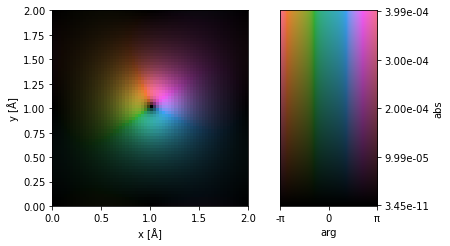

In [52]:
transition_images = transition_potentials.to_images()
transition_images[0].show(cbar=True);

<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>

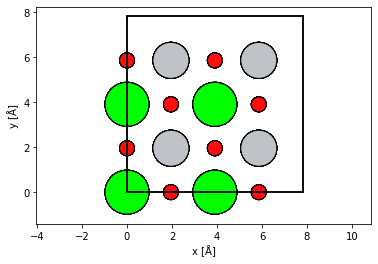

In [63]:
atoms = read('../data/srtio3_100.cif') * (2, 2, 13)

show_atoms(atoms)

In [64]:
# frozen_phonons = FrozenPhonons(atoms, num_configs=4, sigmas=0.085, ensemble_mean=True)

potential = Potential(atoms, 
                      gpts=64, 
                      slice_thickness=2, 
                      parametrization='lobato', 
                      projection='infinite')

waves = Probe(energy=100e3, semiangle_cutoff=21)

waves.grid.match(potential)

detectors = [AnnularDetector(inner=0, outer=25), PixelatedDetector(max_angle=25)]

scan = GridScan.from_fractional_coordinates(potential, end=(.5, .5))

#transition_potentials = O_transitions.get_transition_potentials(extent=2, gpts=128, energy=100e3)

measurements = waves.scan(potential, 
                    detectors=detectors, 
                    scan=scan,
                    # ctf = CTF(semiangle_cutoff=25), # post sample aperture if necessary
                    transition_potentials=transition_potentials,
                    )

measurements.compute()

In [65]:
image, diffraction_patterns = measurements

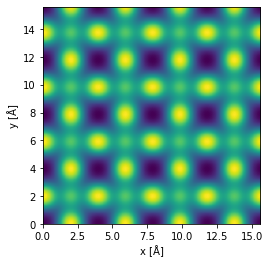

In [66]:
image.interpolate(.1).tile((4, 4)).show();

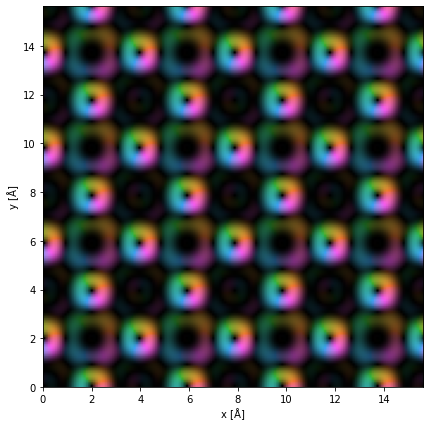

In [67]:
diffraction_patterns.center_of_mass().interpolate(.1).tile((4, 4)).show(figsize=(7,7));